# Préparation des données et Génération des features

## Objectif

L'objectif de ce notebook est de créer les Class permettrant de générer les données d'entrainement, de test et de validation.
Ce notebook est créé en premier jet et j'y reviendrai au fur et à mesure des besoins et des avancées pour avoir davantage de features/possibilitées de génération que les différents modèles peuvent demander. 



## Import des librairies

In [1]:
import os  # for path dirs and files
import tqdm  # progress bar


# to deal with data
import numpy as np
import pandas as pd

# plot the results
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

import torch

## Récupération des données

In [2]:
df = pd.read_csv(os.path.join('.', 'data', 'data_full_preprocessed.csv'))  # read file
df['day'] = pd.to_datetime(df['day'])                                      # convert the str days to dates
df

,pair,day,return,set
0,AUDCAD,2007-10-23,0.007541,unpredictable
1,AUDCAD,2007-10-24,0.003915,unpredictable
2,AUDCAD,2007-10-25,0.002523,unpredictable
3,AUDCAD,2007-10-26,0.005835,unpredictable
4,AUDCAD,2007-10-29,0.007962,unpredictable
...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test
225204,ZARJPY,2020-12-28,0.004670,test
225205,ZARJPY,2020-12-29,-0.002113,test
225206,ZARJPY,2020-12-30,-0.006775,test


## Clip des données

Il peut être intéressant de pouvoir faire un clip des données pour ne pas être trop attiré par les valeurs extrêmes. 

Comme on l'a vu dans le notebook 2 précédent, les données ***return*** sont centrées en zéro. Il est alors parfaitement possible de faire un clip avec une valeur absolue. 

In [3]:
def clip_serie(serie, clip_value=None, return_ratio=False):
    if clip_value is None:
        if return_ratio: return serie, 0
        else: return serie
    # clip the values
    clipped_serie = serie.clip(-clip_value, clip_value)
    
    # get the ratio of clipped value
    clip_ratio = (serie != clipped_serie).sum() / len(serie)
    if return_ratio: return clipped_serie, clip_ratio
    else: return clipped_serie

Examinons si une valeur de clip est intéressante en essayant diverses seuils

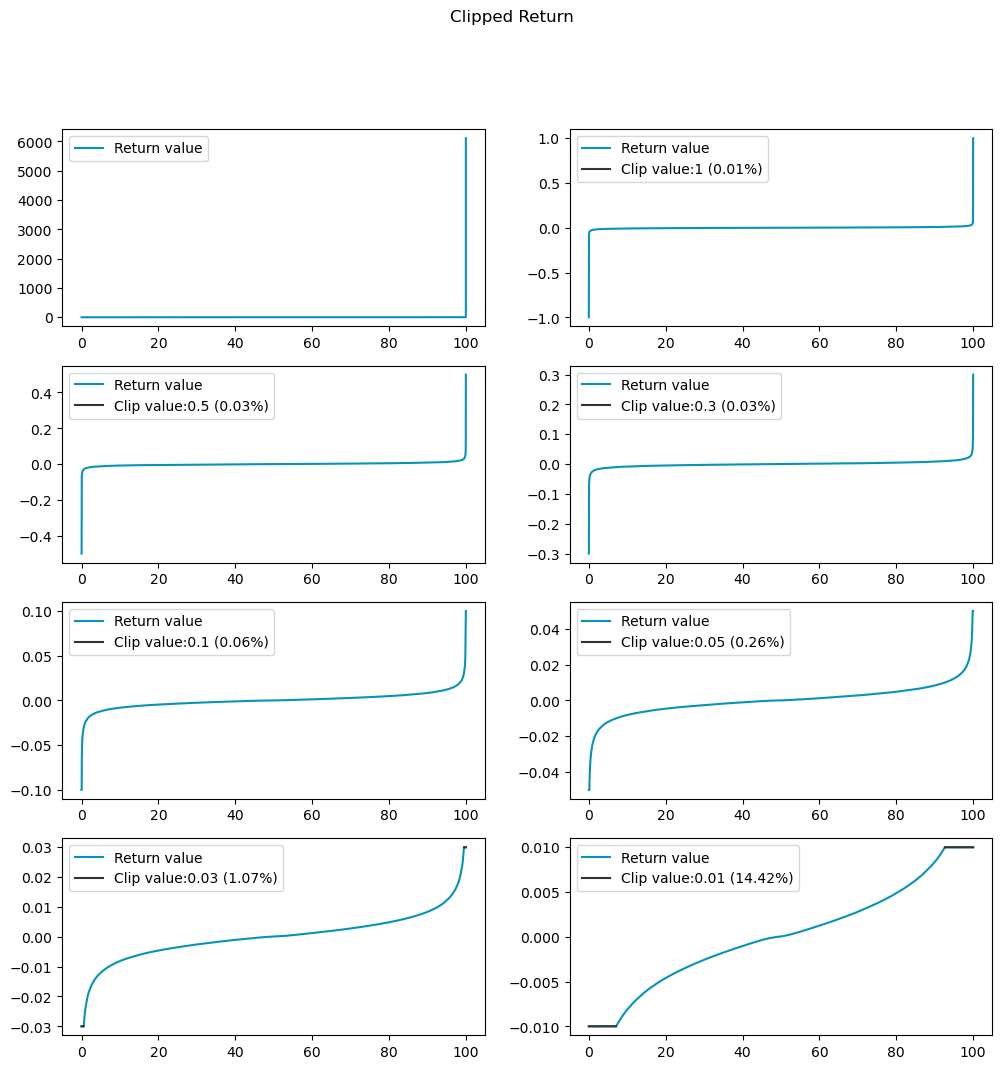

In [4]:
# set a wide range of clip values including no clip at all
clip_values = [None, 1, 0.5, 0.3, 0.1, 0.05, 0.03, 0.01]

# create an ax for each clip value to plot the return values distribution
plt.rcParams['figure.figsize'] = [12, 12]
fig, axes = plt.subplots(4, 2)
axes = np.array(axes).flatten()

# for each clip value plot the return values distribution
for clip_value, ax in zip(clip_values, axes):
    
    # get the clipped values and the ratio of values clipped
    # and sort the clipped return to have a cumulative distribution
    clipped_return, clip_ratio = clip_serie(df['return'], clip_value, return_ratio=True)
    clipped_return = np.array(sorted(clipped_return))
    
    # plot the cumulative distribution by percentage
    percent = np.linspace(0, 100, len(clipped_return))
    ax.plot(percent, clipped_return, color='#0593ba', label='Return value')
    
    # underline the clipped values
    if clip_value is not None:
        for sign in [1, -1]:
            idx_clipped = np.where(clipped_return==clip_value * sign)
            label = f'Clip value:{clip_value} ({clip_ratio*100:.2f}%)' if sign == 1 else '' # only one time display
            ax.plot(percent[idx_clipped], clipped_return[idx_clipped], color='#333333', label=label)
    ax.legend()
    
# show them of course 
plt.suptitle('Clipped Return')
plt.show()
plt.rcParams['figure.figsize'] = [12, 4]

Ce que l'on peut constater, c'est qu'il est primordial de faire un clip. Il y a des valeurs de retours qui sont soit aberrantes dans le pire des cas, et dans le meilleur des cas qui sont des anomalies. 

Lors de ce mémoire, il ne s'agit pas de détection d'anomalie mais plutôt d'essayer de comparer la robustesse des modèles dans les cas généraux. Alors garder ces anomalies pourrait biaiser fortement non modèles qui seront attirés par les fortes valeurs. Il est donc important d'effectuer un clip. 

Maintenant, reste à savoir quel seuil garder. Il faut faire un compromis entre les données qu'on clip (donc perte de donnée) et la centralisation des données (généralisation). Les valeurs 0.1 à 0.03 correspondant à +- 10% et 3% de d'évolution de valeur d'une journée à l'autre semblent être adéquates. 
En l'occurence, si on priosise la généralisation et qu'on accepté une "perte de données" à 1% alors on peut obter pour un seuil de clip à 0.03. 

In [5]:
clip_value = 0.03
df['return'] = clip_serie(df['return'], clip_value=clip_value) 
df.describe()

,return
count,225208.000000
mean,0.000098
std,0.007684
min,-0.030000
25%,-0.003503
50%,0.000040
75%,0.003743
max,0.030000


## Look Back Input création

Maintenant, ce que nous voulons c'est avoir un vecteur avec l'historique des valeurs pour une paire de devises sur les D derniers jours de trade. On place cette valeur à 240 qui correspond à presque un an de trade.

Afin de permettre une visualisation on appliquera cette fonction à EURUSD, AUDCAD, ZARJPY respectivement sur leur premier jour du set training, validation et test. 

$D = \text{n_look_back} = 240$

Mais avant cela, on doit pouvoir donner un numéro à chaque jour puisque nous avons des jours de la semaine uniquement qui sautent les weekends (ce qui implique qu'on ne peut pas additionner/soustraire les dates)

In [6]:
df['day_count'] = df.groupby('pair').cumcount()
df

,pair,day,return,set,day_count
0,AUDCAD,2007-10-23,0.007541,unpredictable,0
1,AUDCAD,2007-10-24,0.003915,unpredictable,1
2,AUDCAD,2007-10-25,0.002523,unpredictable,2
3,AUDCAD,2007-10-26,0.005835,unpredictable,3
4,AUDCAD,2007-10-29,0.007962,unpredictable,4
...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,2639
225204,ZARJPY,2020-12-28,0.004670,test,2640
225205,ZARJPY,2020-12-29,-0.002113,test,2641
225206,ZARJPY,2020-12-30,-0.006775,test,2642


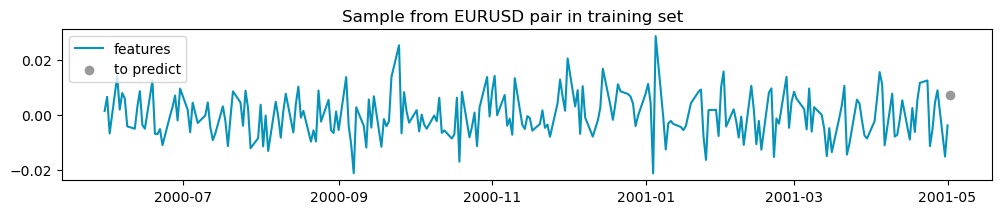

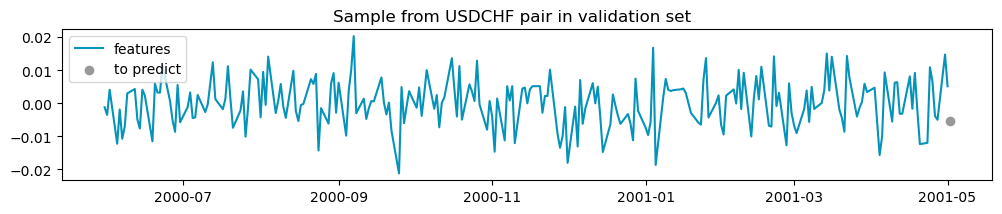

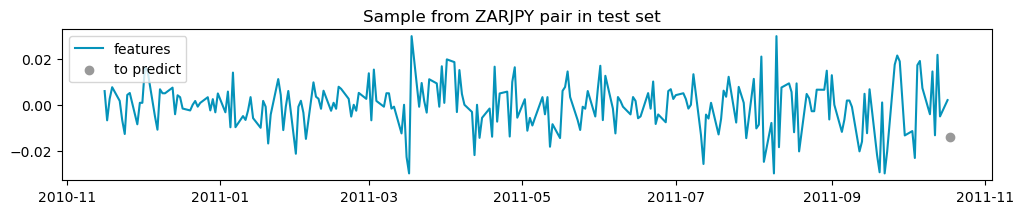

In [7]:
n_look_back = 240

pairs = ['EURUSD', 'USDCHF', 'ZARJPY']
splits = ['training', 'validation', 'test']

# first row available (can be the first day if no shuffle and sorted before)
idx = 0
plt.rcParams['figure.figsize'] = [12, 2]

for pair, split in zip(pairs, splits):
    
    # get an arbitrary row on which to have the day to predict
    # the (df['pair']==pair) condition is useful here but will not be used later
    # as the idx will loop and will not be fixed (to idx=0)
    row = df[(df['pair']==pair) & (df['set'] == split)].iloc[idx]
    
    # compute the number of the day to look back (no day subtraction as we don't have weekend days in the dataset)
    first_day_look_back = row.day_count - n_look_back
    
    # get the range number of the days to look back as a feature
    days_to_look_back = range(first_day_look_back, row.day_count) # not include of course
    
    # get the days to look back as a feature for a given pair and day to predict
    rows_look_back = df[(df['pair']==row.pair) & (df['day_count'].isin(days_to_look_back))]
    
    # X as features, y as target
    X, y = rows_look_back['return'], row['return']
    
    # plot it 
    plt.plot(rows_look_back['day'], X, color='#0593ba', label='features')
    plt.scatter(row['day'], y, color='#999999', label='to predict')
    plt.legend(loc='upper left')
    plt.suptitle(f'Sample from {pair} pair in {split} set')
    plt.show()
plt.rcParams['figure.figsize'] = [12, 4]



## Economie de temps

En arrivant à ce stade, on se rend compte qu'il va être très long et redondant d'avoir à calculer à chaque fois les 240 derniers jours. 
Alors on peut faire une économie de temps de calcul en contrepartie de mémoire vive. 
Pour cela, on calcule une fois les 240 derniers jours pour chaque ligne sous forme d'un array numpy

In [8]:
# get an abritraty day to compute the time needed to get the days to look back 
row = df[(df['pair']=='EURUSD') & (df['set'] == 'training')].iloc[0]
first_day_look_back = row.day_count - n_look_back
days_to_look_back = range(first_day_look_back, row.day_count) # not include of course

# compute an approximation of the time it needs to get the days to look back  
%timeit rows_look_back = df[(df['pair']==row.pair) & (df['day_count'].isin(days_to_look_back))]

29.2 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# convert it into a time approximation for one complete loop over the dataset (minutes)
ms_compute_from_timeit = 31 
ms_to_sec = 1 / 1000
sec_to_minute = 1 / 60
estimated_minutes = len(df[df['set'] != 'unpredictable']) * 13.6 * ms_to_sec * sec_to_minute 

print(f'Computing look back days return estimation: {estimated_minutes:.2f} minute(s)')

Computing look back days return estimation: 47.44 minute(s)


En effet on peut estimer le temps de ce calcul pour faire une boucle complète à environ 45 minutes donc voyons si on a l'espace mémoire pour garder ce vecteur dans le dataset une fois calculé.

Faisons cela une bon fois pour toute (on peut se prendre un bon café pendant ce temps)

In [10]:
RE_RUN = True  # to not to have to re run at each time as it is very long

In [11]:
def get_look_back_days(df, row):
    # compute the number of the day to look back (no day subtraction as we don't have weekend days in the dataset)
    first_day_look_back = row.day_count - n_look_back
 
    # get the range number of the days to look back as a feature
    days_to_look_back = range(first_day_look_back, row.day_count) # not include of course

    # get the days to look back as a feature for a given pair and day to predict
    rows_look_back = df[(df['pair']==row.pair) & (df['day_count'].isin(days_to_look_back))]

    return list(rows_look_back['return'].values)
    
    
    
if RE_RUN:
    new_df = pd.DataFrame()
    
    unique_pairs = np.unique(df['pair'])
    for pair in tqdm.tqdm(sorted(unique_pairs)):
        pair_df = df[df['pair'] == pair]
        pair_df['look_back_days'] = pair_df.apply(lambda row: get_look_back_days(pair_df, row), axis=1)
        new_df = new_df.append(pair_df.sort_values(['day']))
    
    # remove the non-n_look_back lists (unpredictable)
    new_df.loc[new_df['set'] == 'unpredictable', 'look_back_days'] = np.nan
    
    # convert the look_back_days list into columns to save memory and time when loading it
    look_back_days = new_df['look_back_days'].apply(pd.Series)
    # set the name of the columns
    look_back_days.columns = [f't_{day}' for day in range(n_look_back, 0, -1)]
    # set the new columns for each feature
    new_df[look_back_days.columns] = look_back_days
    # drop the unused column
    new_df = new_df.drop(columns=['look_back_days'])

    
    print('Saving...')
    file_path = os.path.join('.', 'data', 'data_optimized.csv')
    # it is a big dataset so lets go chunk by chunk
    chunk_idx = np.array_split(new_df.index, 100)
    for i, idx in enumerate(tqdm.tqdm(chunk_idx)):
        if i == 0:
            new_df.loc[idx].to_csv(file_path, mode='w', index=False)
        else:
            new_df.loc[idx].to_csv(file_path, header=None, mode='a', index=False)


  0%|                                                                      | 0/66 [00:00<?, ?it/s]<ipython-input-11-64a06aba8af2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_df['look_back_days'] = pair_df.apply(lambda row: get_look_back_days(pair_df, row), axis=1)
  0%|                                                                     | 0/100 [00:00<?, ?it/s]

Saving...


100%|███████████████████████████████████████████████████████████| 100/100 [14:14<00:00,  8.55s/it]


In [12]:
# read file
df = pd.read_csv(os.path.join('.', 'data', 'data_optimized.csv'))
# convert the str days to dates
df['day'] = pd.to_datetime(df['day'])

# retrieve the list of the look back days inputs
t_minus_columns = [f't_{day}' for day in range(n_look_back, 0, -1)]
df['look_back_days'] = df[t_minus_columns].values.tolist()
df.loc[df['t_1'].isna(), 'look_back_days'] = np.nan
df = df.drop(columns=t_minus_columns)
df

,pair,day,return,set,day_count,look_back_days
0,AUDCAD,2007-10-23,0.007541,unpredictable,0,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,1,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,2,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,3,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,4,NaN
...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,2639,"[-0.00248756218905477, -0.009056306601916251, ..."
225204,ZARJPY,2020-12-28,0.004670,test,2640,"[-0.009056306601916251, -0.011788079470198665,..."
225205,ZARJPY,2020-12-29,-0.002113,test,2641,"[-0.011788079470198665, 0.00616539337890365, -..."
225206,ZARJPY,2020-12-30,-0.006775,test,2642,"[0.00616539337890365, -0.009990675369655031, -..."


## Sanity check

In [13]:
unpredicatble_with_value = df[df['set'] == 'unpredictable'].dropna()
print(f'Number of unwanted look back days on unpredictable values: {len(unpredicatble_with_value)}')

Number of unwanted look back days on unpredictable values: 0


In [14]:
predicatble_with_nan = df[(df['set'] != 'unpredictable') & (df['look_back_days'].isna())]
print(f'Number of unwanted look back days on predictable Nan: {len(predicatble_with_nan)}')

Number of unwanted look back days on predictable Nan: 0


In [15]:
non_n_look_back_value = df[df['set'] != 'unpredictable'].apply(lambda row: len(row['look_back_days']) != n_look_back, axis=1)
print(f'Number of non {n_look_back}-look-back days: {non_n_look_back_value.sum()}')

Number of non 240-look-back days: 0


## Analyse de la volatilité des historiques à 240 jours

Ce qui pourrait être intéressant, c'est d'analyser la distribution des moyennes et des écarts types des historiques à 240 jours. 

In [16]:
def get_mean_std(row):
    if row.set == 'unpredictable': return np.nan, np.nan
    else: return np.mean(row.look_back_days), np.std(row.look_back_days)

df['mean'], df['std'] = zip(*df.apply(lambda row: get_mean_std(row), axis=1).values)
df

,pair,day,return,set,day_count,look_back_days,mean,std
0,AUDCAD,2007-10-23,0.007541,unpredictable,0,NaN,NaN,NaN
1,AUDCAD,2007-10-24,0.003915,unpredictable,1,NaN,NaN,NaN
2,AUDCAD,2007-10-25,0.002523,unpredictable,2,NaN,NaN,NaN
3,AUDCAD,2007-10-26,0.005835,unpredictable,3,NaN,NaN,NaN
4,AUDCAD,2007-10-29,0.007962,unpredictable,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
225203,ZARJPY,2020-12-25,-0.002822,test,2639,"[-0.00248756218905477, -0.009056306601916251, ...",-0.000015,0.011358
225204,ZARJPY,2020-12-28,0.004670,test,2640,"[-0.009056306601916251, -0.011788079470198665,...",-0.000017,0.011359
225205,ZARJPY,2020-12-29,-0.002113,test,2641,"[-0.011788079470198665, 0.00616539337890365, -...",0.000041,0.011347
225206,ZARJPY,2020-12-30,-0.006775,test,2642,"[0.00616539337890365, -0.009990675369655031, -...",0.000081,0.011322


C:\Users\athevenot\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\athevenot\AppData\Roaming\Python\Python38\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


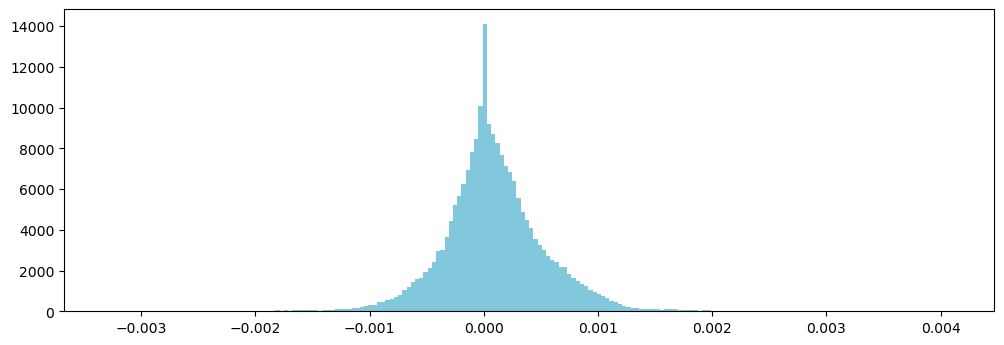

In [17]:
plt.hist(df['mean'], bins=200, color='#0593ba', alpha=0.5)
pass

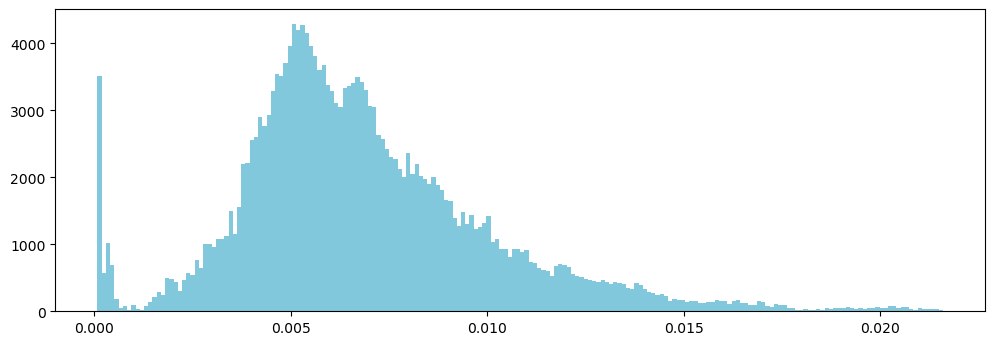

In [18]:
plt.hist(df['std'], bins=200, color='#0593ba', alpha=0.5)
pass

On voit donc qu'on a affaire à des valeurs maintenant très faibles. D'ailleurs elles sont les variations globales suivent un semblant de loi gaussienne. 
Rajoutons à cela qu'il peut être intéressant d'homogéniéïser davantage nos données avec la moyenne et l'écart type en le standardisant. C'est donc cette dernière pensée qu'on implémentera dans notre classe pour générer le dataset.

## Création Class Dataset

In [19]:
class Dataset:
    
    def __init__(self, path=None, to_torch=False):
        self.to_torch = to_torch 
        if path is None:
            self.df = None
        else:
            # read file
            print('Import file...')
            self.df = pd.read_csv(path)
            
            # convert the str days to dates
            print('Convert day to date...')
            self.df['day'] = pd.to_datetime(self.df['day'])
            
            # retrieve the list of the look back days inputs
            print('Convert columns to list...')
            t_minus_columns = [f't_{day}' for day in range(n_look_back, 0, -1)]
            self.df['look_back_days'] = self.df[t_minus_columns].values.tolist()
            self.df.loc[self.df['t_1'].isna(), 'look_back_days'] = np.nan
            self.df = self.df.drop(columns=t_minus_columns)
            
    def split(self):
        # isolate the training dataset
        training_dataset = Dataset()
        training_dataset.df = self.df[self.df['set'] == 'training']
        
        # isolate the validation dataset 
        validation_dataset = Dataset()
        validation_dataset.df = self.df[self.df['set'] == 'validation']
        
        # isolate the test dataset
        test_dataset = Dataset()
        test_dataset.df = self.df[self.df['set'] == 'test']
        
        return training_dataset, validation_dataset, test_dataset
        
    def __len__(self):
        return len(self.df) if self.df is not None else 0
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        X, y = np.array(row['look_back_days']), row['return']
        if self.to_torch:
            X, y = torch.from_numpy(x), torch.tensor(y)
        return X, y



In [20]:
dataset = Dataset(os.path.join('.', 'data', 'data_optimized.csv'))
print(f'Length of the full dataset: {len(dataset)}')
training_dataset, validation_dataset, test_dataset = dataset.split()
print(f'Length of the training dataset: {len(training_dataset)}')
print(f'Length of the validation dataset: {len(validation_dataset)}')
print(f'Length of the test dataset: {len(test_dataset)}')


Import file...
Convert day to date...
Convert columns to list...
Length of the full dataset: 225208
Length of the training dataset: 25647
Length of the validation dataset: 23817
Length of the test dataset: 159839


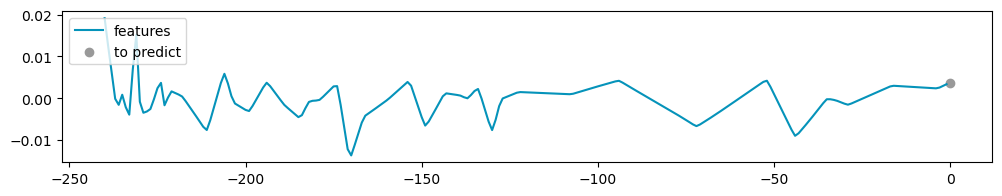

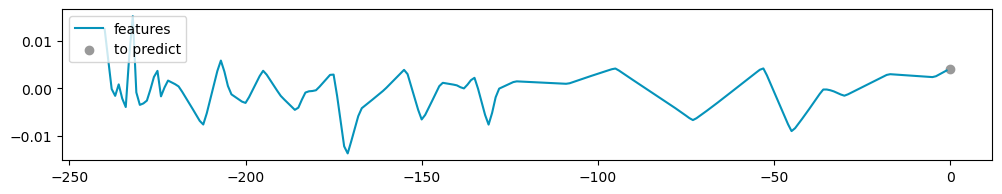

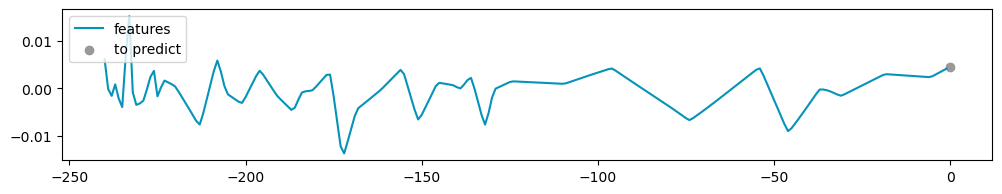

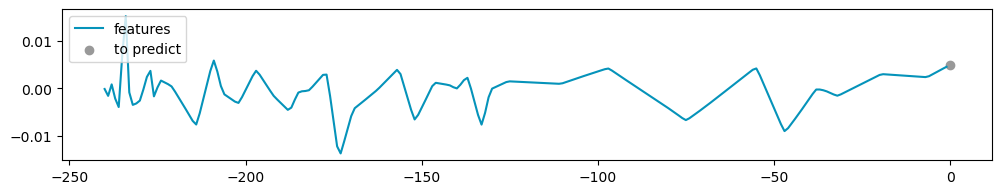

In [21]:
plt.rcParams['figure.figsize'] = [12, 2]

days = range(-240, 0)
for i in range(4):
    X, y = training_dataset[i]
    plt.plot(days, X, color='#0593ba', label='features')
    plt.scatter(0, y, color='#999999', label='to predict')
    plt.legend(loc='upper left')
    plt.show()
plt.rcParams['figure.figsize'] = [12, 4]


On peut donc tout mettre dans un fichier que l'on nommera `dataset.py`

```python

import torch
import numpy as np
import pandas as pd

n_look_back = 240

class Dataset:

    def __init__(self, path=None, to_torch=False):
        self.to_torch = to_torch
        if path is None:
            self.df = None
        else:
            # read file
            print('Import file...')
            self.df = pd.read_csv(path)

            # convert the str days to dates
            print('Convert day to date...')
            self.df['day'] = pd.to_datetime(self.df['day'])

            # retrieve the list of the look back days inputs
            print('Convert columns to list...')
            t_minus_columns = [f't_{day}' for day in range(n_look_back, 0, -1)]
            self.df['look_back_days'] = self.df[t_minus_columns].values.tolist()
            self.df.loc[self.df['t_1'].isna(), 'look_back_days'] = np.nan
            self.df = self.df.drop(columns=t_minus_columns)

    def split(self):
        # isolate the training dataset
        training_dataset = Dataset()
        training_dataset.df = self.df[self.df['set'] == 'training']

        # isolate the validation dataset
        validation_dataset = Dataset()
        validation_dataset.df = self.df[self.df['set'] == 'validation']

        # isolate the test dataset
        test_dataset = Dataset()
        test_dataset.df = self.df[self.df['set'] == 'test']

        return training_dataset, validation_dataset, test_dataset

    def __len__(self):
        return len(self.df) if self.df is not None else 0

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        X, y = np.array(row['look_back_days']), row['return']
        if self.to_torch:
            X, y = torch.from_numpy(x), torch.tensor(y)
        return X, y

```

## Sanity check

Import file...
Convert day to date...
Convert columns to list...
Length of the full dataset: 225208
Length of the training dataset: 25647
Length of the validation dataset: 23817
Length of the test dataset: 159839


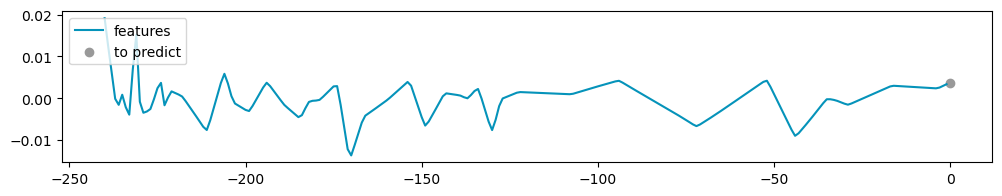

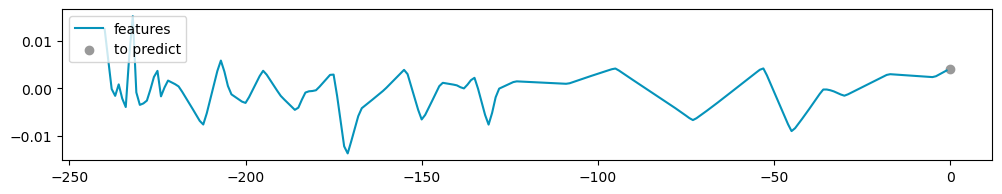

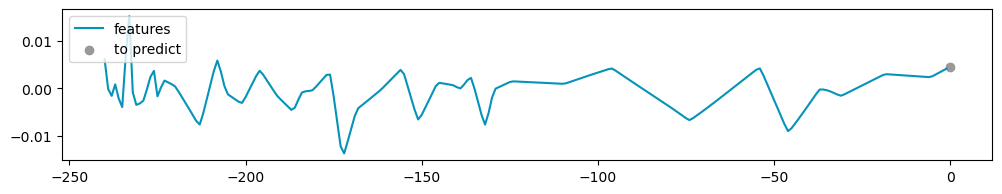

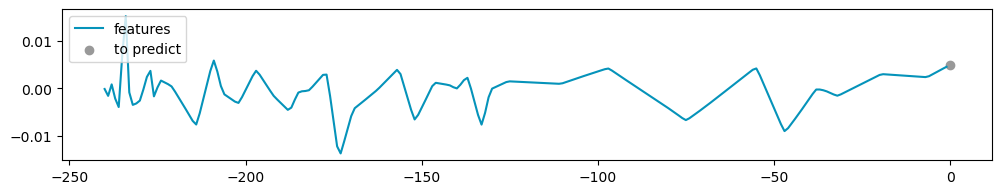

In [22]:
from dataset import Dataset

dataset = Dataset(os.path.join('.', 'data', 'data_optimized.csv'))
print(f'Length of the full dataset: {len(dataset)}')
training_dataset, validation_dataset, test_dataset = dataset.split()
print(f'Length of the training dataset: {len(training_dataset)}')
print(f'Length of the validation dataset: {len(validation_dataset)}')
print(f'Length of the test dataset: {len(test_dataset)}')

plt.rcParams['figure.figsize'] = [12, 2]

days = range(-240, 0)
for i in range(4):
    X, y = training_dataset[i]
    plt.plot(days, X, color='#0593ba', label='features')
    plt.scatter(0, y, color='#999999', label='to predict')
    plt.legend(loc='upper left')
    plt.show()
plt.rcParams['figure.figsize'] = [12, 4]
